# Post-MVP Modeling

The purpose of this notebook is to improve the final model aka "Minimum Viable Product" that predicted with an F1 of 0.3955.

In [2]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle

# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

In [3]:
# custom fuctions

import sys
sys.path.insert(0, '../src')
# module_path = sys.path.insert(0, '../src')

# if module_path not in sys.path:
#     sys.path.append(module_path)

import helper_functions as helpers

## Method 1: Linear SVM with Count Vectorization

### Importing X and y from `nlp_preprocesing.ipynb`

In [4]:
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

In [5]:
# setting up stop words
stop_words = set(stopwords.words('english'))

### TTS & CountVectorize

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

In [7]:
# using count vectorizor
count = CountVectorizer(stop_words=stop_words)

In [8]:
# fitting to the train and test set
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

### Linear SVM Model (MVP)

In [9]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

In [10]:
%%time 
# 20 seconds to run

# fit the training dataset on the classifier
SVM_baseline.fit(X_train_count, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(X_test_count)

CPU times: user 23.3 s, sys: 499 ms, total: 23.8 s
Wall time: 24.7 s


In [11]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2712
Recall: 0.5365
F1 Score: 0.3603
Weighted F1 Score: 0.9104


Unfortunately this model performed worse than the TFIDF version of this model, which had an F1 of .3955. Whereas this one has an F1 of .3603.

Maybe we can test out other baselines and see how they perform with CountVectorizor

### Random Forest

In [12]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

In [13]:
%%time
# 14 seconds to run

rf_baseline.fit(X_train_count, y_train)
rf_test_preds = rf_baseline.predict(X_test_count)

CPU times: user 14.5 s, sys: 182 ms, total: 14.7 s
Wall time: 15.1 s


In [14]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
helpers.evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.3173
Recall: 0.2883
F1 Score: 0.3021
Weighted F1 Score: 0.9247


This improved the original F1 of .232, but this F1 score is still pretty low compared to the TFIDF Linear SVM model.

### Logisitic Regression

In [15]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [16]:
%%time
# 1 second to run

logreg_baseline.fit(X_train_count, y_train)
logreg_test_preds = logreg_baseline.predict(X_test_count)

CPU times: user 1.41 s, sys: 80.2 ms, total: 1.49 s
Wall time: 568 ms


In [17]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_f1_weighted = f1_score(y_test, logreg_test_preds, average='weighted')

# printing scores
helpers.evaluation(logreg_precision, logreg_recall, logreg_f1_score, logreg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2898
Recall: 0.6241
F1 Score: 0.3958
Weighted F1 Score: 0.9121


So this beat the TFIDF Log Reg score of .3878, and was slightly better than .3955 from the TFIDF Linear SVM. Let's try Naive Bayes next before trying out grid search on this model.

In [18]:
target_names = ['class 0', 'class 1']
print('-'*7 + ' Log Reg Baseline with Count Vectorizor ' + '-'*6)
print(classification_report(y_test, logreg_test_preds, target_names=target_names))

------- Log Reg Baseline with Count Vectorizor ------
              precision    recall  f1-score   support

     class 0       0.98      0.91      0.94      4683
     class 1       0.29      0.62      0.40       274

    accuracy                           0.89      4957
   macro avg       0.63      0.77      0.67      4957
weighted avg       0.94      0.89      0.91      4957



![img](../visualizations/mvp_class_report.png)

If we compare the classification report for both models, it's worth noting that this model predicts the "Not Hate Speech" label slightly worse than the original.

There's no change in the prediction of the "Hate Speech" label, but that's what needs to be changed. If there's no increase after grid search, then it wont be worth implimenting into the final_notebook.

### Naive Bayes

In [19]:
baseline_bayes = MultinomialNB(alpha = .01)

In [20]:
%%time
baseline_bayes.fit(X_train_count, y_train)
bayes_test_preds = baseline_bayes.predict(X_test_count)

CPU times: user 16.7 ms, sys: 2.85 ms, total: 19.6 ms
Wall time: 8.84 ms


In [21]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
helpers.evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4459
Recall: 0.2409
F1 Score: 0.3128
Weighted F1 Score: 0.9332


There was a big increase from the original Bayes model that had an F1 of .1923. However, .3128 still isn't good enough.

## Improving Logistic Regression Model

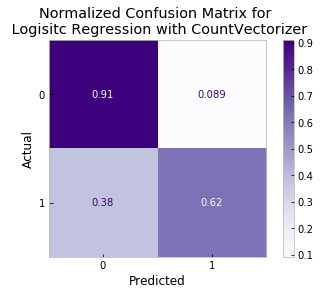

In [27]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(logreg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logisitc Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
# plt.savefig('./visualizations/normalized_count_log_reg_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

Interestingly, this confusion matrix shows a much better score for the TPR! It bumped up from 0.44 to 0.62.

Before performing grid search, let's try Smote and Tomek Links to improve this model.